### Config the model

In [1]:
from langchain_google_genai import ChatGoogleGenerativeAI
model=ChatGoogleGenerativeAI(model='gemini-2.5-flash-preview-05-20')
output=model.invoke("hi")
print(output.content)

Hi there! How can I help you today?


### Config the embedding model

In [2]:
import os
os.environ['HF_TOKEN']=os.getenv("HUGGINGFACEHUB_API_TOKEN")

In [3]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="BAAI/bge-small-en")
len(embeddings.embed_query("hi"))

c:\Users\Artur Dragunov\Documents\GIT\agentic-ai-bootcamp\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


384

## lets take a data embedd it and store in VDB

In [4]:
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [5]:
loader=DirectoryLoader("../data2",glob="./*.txt",loader_cls=TextLoader) 
# parent directory is ../data2, glob is the pattern to match the files,
#  loader_cls is the class to use to load the files

In [6]:
docs=loader.load()

In [7]:
docs

[Document(metadata={'source': '..\\data2\\usa.txt'}, page_content="ðŸ‡ºðŸ‡¸ Overview of the U.S. Economy\nThe United States of America possesses the largest economy in the world in terms of nominal GDP, making it the most powerful economic force globally. It operates under a capitalist mixed economy, where the private sector dominates, but the government plays a significant regulatory and fiscal role. With a population of over 335 million people and a high level of technological advancement, the U.S. economy thrives on a foundation of consumer spending, innovation, global trade, and financial services. It has a highly diversified structure with strong sectors in technology, healthcare, finance, real estate, defense, and agriculture.\n\nU.S. GDP â€“ Size, Composition, and Global Share\nAs of 2024, the United Statesâ€™ nominal GDP is estimated to be around $28 trillion USD, accounting for approximately 25% of the global economy. It ranks #1 in the world by nominal GDP, far ahead of China

In [8]:
docs[0].page_content

"ðŸ‡ºðŸ‡¸ Overview of the U.S. Economy\nThe United States of America possesses the largest economy in the world in terms of nominal GDP, making it the most powerful economic force globally. It operates under a capitalist mixed economy, where the private sector dominates, but the government plays a significant regulatory and fiscal role. With a population of over 335 million people and a high level of technological advancement, the U.S. economy thrives on a foundation of consumer spending, innovation, global trade, and financial services. It has a highly diversified structure with strong sectors in technology, healthcare, finance, real estate, defense, and agriculture.\n\nU.S. GDP â€“ Size, Composition, and Global Share\nAs of 2024, the United Statesâ€™ nominal GDP is estimated to be around $28 trillion USD, accounting for approximately 25% of the global economy. It ranks #1 in the world by nominal GDP, far ahead of China (which ranks 2nd). The U.S. GDP per capita is also among the high

In [9]:
text_splitter=RecursiveCharacterTextSplitter(
    chunk_size=200,
    chunk_overlap=50
)

In [11]:
new_docs=text_splitter.split_documents(documents=docs)

In [12]:
new_docs # chunks of data

[Document(metadata={'source': '..\\data2\\usa.txt'}, page_content='ðŸ‡ºðŸ‡¸ Overview of the U.S. Economy'),
 Document(metadata={'source': '..\\data2\\usa.txt'}, page_content='The United States of America possesses the largest economy in the world in terms of nominal GDP, making it the most powerful economic force globally. It operates under a capitalist mixed economy,'),
 Document(metadata={'source': '..\\data2\\usa.txt'}, page_content='It operates under a capitalist mixed economy, where the private sector dominates, but the government plays a significant regulatory and fiscal role. With a population of over 335 million people and a'),
 Document(metadata={'source': '..\\data2\\usa.txt'}, page_content='a population of over 335 million people and a high level of technological advancement, the U.S. economy thrives on a foundation of consumer spending, innovation, global trade, and financial services.'),
 Document(metadata={'source': '..\\data2\\usa.txt'}, page_content='innovation, global 

In [13]:
doc_string=[doc.page_content for doc in new_docs] # we dropped the metadata

In [15]:
doc_string[:5]

['ðŸ‡ºðŸ‡¸ Overview of the U.S. Economy',
 'The United States of America possesses the largest economy in the world in terms of nominal GDP, making it the most powerful economic force globally. It operates under a capitalist mixed economy,',
 'It operates under a capitalist mixed economy, where the private sector dominates, but the government plays a significant regulatory and fiscal role. With a population of over 335 million people and a',
 'a population of over 335 million people and a high level of technological advancement, the U.S. economy thrives on a foundation of consumer spending, innovation, global trade, and financial services.',
 'innovation, global trade, and financial services. It has a highly diversified structure with strong sectors in technology, healthcare, finance, real estate, defense, and agriculture.']

In [16]:
len(doc_string)

56

In [17]:
db=Chroma.from_documents(new_docs,embeddings) # in-memory vector DB

In [18]:
retriever=db.as_retriever(search_kwargs={"k": 3})

In [19]:
retriever.invoke("industrial growth of usa?")

[Document(metadata={'source': '..\\data2\\usa.txt'}, page_content='Looking forward, the U.S. economy is expected to grow at a moderate pace, powered by innovation in AI, green energy, robotics, biotech, and quantum computing. The Biden administrationâ€™s Inflation'),
 Document(metadata={'source': '..\\data2\\usa.txt'}, page_content='ðŸ‡ºðŸ‡¸ Overview of the U.S. Economy'),
 Document(metadata={'source': '..\\data2\\usa.txt'}, page_content='The U.S. economy remains the engine of global growth, backed by unmatched innovation, financial dominance, and a strong institutional framework. Its $28 trillion GDP and influence over global')]

## creation of pydantic class

In [20]:
import operator
from typing import List
from pydantic import BaseModel , Field
from langchain.prompts import PromptTemplate
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph,END

In [21]:
from typing import Literal
class TopicSelectionParser(BaseModel):
  Topic: Literal["USA", "Not Related"] = Field(description="selected topic")
  Reasoning: str = Field(description='Reasoning behind topic selection')
# I would do it vice versa -> first Reasoning then Topic. Less probability for halusination    

In [22]:
from langchain.output_parsers import PydanticOutputParser

In [23]:
parser=PydanticOutputParser(pydantic_object=TopicSelectionParser)

Pydantic's PydanticOutputParser.get_format_instructions() always returns JSON format instructions by default. It's not configurable to other formats.
The reason is JSON because:

Pydantic models are designed around JSON schema - they naturally serialize to/from JSON


...

The output should be formatted as a valid JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"], "type": "object"}
the object {"foo": ["bar", "baz"]} is a valid instance of the schema. Alternatively, the object {"foo": ["bar"]} is also a valid instance of the schema. Alternatively, the object {"foo": ["bar", "baz", "qux"]} is also a valid instance of the schema.

Here is the output schema:
{"properties": {"Topic": {"title": "Topic", "description": "selected topic", "type": "string"}, "Reasoning": {"title": "Reasoning", "description": "Reasoning behind topic selection", "type": "string"}}, "required": ["Topic", "Reasoning"], "type": "object"}

In [ ]:
from pprint import pprint
pprint(parser.get_format_instructions())

In [ ]:
'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"Topic": {"description": "selected topic", "title": "Topic", "type": "string"}, "Reasoning": {"description": "Reasoning behind topic selection", "title": "Reasoning", "type": "string"}}, "required": ["Topic", "Reasoning"]}\n```'

### this below agentstate is just for the explanation like how state works step by step

In [26]:
Agentstate={}

In [27]:
Agentstate["messages"]=[] # we created a key and assigned an empty list to it


In [28]:
Agentstate # this is how agent state will look like at the beginning

{'messages': []}

In [29]:
Agentstate["messages"].append("hi how are you?")

In [30]:
Agentstate

{'messages': ['hi how are you?']}

In [31]:
Agentstate["messages"].append("what are you doing?")

In [32]:
Agentstate

{'messages': ['hi how are you?', 'what are you doing?']}

In [33]:
Agentstate["messages"].append("i hope everything fine")

In [34]:
Agentstate # the current agent state is three messages inside


{'messages': ['hi how are you?',
  'what are you doing?',
  'i hope everything fine']}

In [35]:
Agentstate["messages"][-1]

'i hope everything fine'

In [36]:
Agentstate["messages"][0]

'hi how are you?'

### this agentstate class you need to inside the stategraph

AgentState is a TypedDict, not a regular class. TypedDict is just a type hint - it doesn't create a constructor.

Thus, instead of state = AgentState(messages=state["messages"]) we call state = {"messages":"hi"}

Why TypedDict instead of regular class?

- Performance - no object overhead, just a dict
- JSON serialization - dicts serialize naturally
- LangGraph compatibility - expects dict-like state
- Immutability patterns - easier to create new state versions

LangGraph works best with TypedDict because it's designed around dict-based state management. The TypedDict gives you type safety without the class overhead.
Think of AgentState as a "shape definition" rather than a "constructor blueprint."

In [37]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
# sequence of base messages and operator.add is a function that adds the messages to the sequence.
# key here is messages. Sequence[BaseMessage] is ['hi how are you?','what are you doing?','i hope everything fine']
# and operator.add is the same as list append

# It's the same as {"messages": [response.Topic]} -> it will be still of AgentState type

In [ ]:
state={"messages":["hi"]}

In [ ]:
state="hi"

In [52]:
# class TopicSelectionParser(BaseModel):
#     Topic:str=Field(description="selected topic")
#     Reasoning:str=Field(description='Reasoning behind topic selection')
# parser=PydanticOutputParser(pydantic_object=TopicSelectionParser)
# parser.get_format_instructions()
from langchain_core.messages import AIMessage
def function_1(state:AgentState): # state should be of AgentState type
    
    question=state["messages"][-1].content # we take latest message (recent) -> this is a BaseMessage object
    
    print("Question",question)
    
    template="""
    Your task is to classify the given user query into one of the following categories: [USA,Not Related]. 
    Only respond with the category name and nothing else.

    User query: {question} # You're inserting a BaseMessage object here
    {format_instructions}
    """
    
    prompt= PromptTemplate(
        template=template,
        input_variable=["question"],
        partial_variables={"format_instructions": parser.get_format_instructions()} # parser was defined outside of the function and it's a PydanticOutputParser
    ) # partial variables are those which enter the prompt but they are not part of the user query
    
    
    chain= prompt | model | parser 
    # we pass the question to the prompt, then the llm model takes the prompt and outputs the response,
		# and then this response is evaluated by parser to have the right format
    response = chain.invoke({"question":question})
    
    print("Parsed response:", response)
    
    return {"messages": [AIMessage(content=response.Topic)]} # now it's like a new message in the state

even though I'm not appending new message directly to state, langgraph does it automatically:

The magic happens in LangGraph's state management, not in your function.
Here's the flow:

Your function returns a new dict:
return {"messages": [AIMessage(content=response.Topic)]}

As state is of AgentState type, it automatically appends output of the function (if it's in right format).
LangGraph receives this and sees:

Key: "messages"
Current state: {"messages": [msg1, msg2, msg3]}
New value: [AIMessage(content=response.Topic)]


LangGraph looks at the AgentState definition:
messages: Annotated[Sequence[BaseMessage], operator.add]

	                                          ^^^^^^^^^^^^

	                                          This tells LangGraph HOW to merge

LangGraph automatically applies operator.add:
 LangGraph does this internally:
state["messages"] = state["messages"] + [AIMessage(content=response.Topic)]


You're not doing the appending - LangGraph is! The operator.add in the type annotation is an instruction to LangGraph's state management system.

If you had used operator.replace instead, it would overwrite the entire messages list rather than append.
This is LangGraph's "reducer" pattern - you return partial state updates, and LangGraph merges them according to the annotations.

In [55]:
from langchain_core.messages import HumanMessage

state = {"messages": [HumanMessage(content="what is a today weather?")]}

In [56]:
function_1(state)

Question what is a today weather?
Parsed response: Topic='Not Related' Reasoning="The user query asks about 'today weather' which is a general topic and does not specify or imply any relation to the USA."


{'messages': [AIMessage(content='Not Related', additional_kwargs={}, response_metadata={})]}

In [57]:
state = {"messages": [HumanMessage(content="what is a GDP of usa??")]}

In [58]:
function_1(state)

Question what is a GDP of usa??
Parsed response: Topic='USA' Reasoning="The user query explicitly mentions 'usa' and asks for its GDP, which directly relates to the 'USA' category."


{'messages': [AIMessage(content='USA', additional_kwargs={}, response_metadata={})]}

In [ ]:
# class TopicSelectionParser(BaseModel):
#     Topic:str=Field(description="selected topic")
#     Reasoning:str=Field(description='Reasoning behind topic selection')

In [60]:
def router(state:AgentState): 
# router is for conditional edges -> depending on the input,
# it will select the next appropriate node
    print("-> ROUTER ->")
    
    last_message=state["messages"][-1].content # Now extract content from AIMessage
    print("last_message:", last_message)
    
    if "usa" in last_message.lower():
        return "RAG Call"
    else:
        return "LLM Call"

workflow.add_conditional_edges(
    "Supervisor",
    router,
    {
        "RAG Call": "RAG"(function_2),
        "LLM Call": "LLM"(function_3),
    }
)

In [61]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [62]:
# RAG Function
def function_2(state:AgentState):
    print("-> RAG Call ->")
    
    question = state["messages"][-2].content 
    # question is the second last message. AI answer is the last message
    
    prompt=PromptTemplate(
        template="""You are an assistant for question-answering tasks.
                  Use the following pieces of retrieved context to answer the question.
									If you don't know the answer, just say that you don't know.
									Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:""",
        
        input_variables=['context', 'question']
    )
# retriever is from RAG db. It searches for similar outputs in db based on question and returns the context    
    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()} 
        | prompt
        | model
        | StrOutputParser()
    )
    result = rag_chain.invoke(question)
    return  {"messages": [AIMessage(content=result)]}

In [63]:
# LLM Function
def function_3(state:AgentState):
    print("-> LLM Call ->")
    question = state["messages"][-2].content
    
    # Normal LLM call
    complete_query = "Anwer the follow question with you knowledge of the real world. Following is the user question: " + question
    response = model.invoke(complete_query)
    return {"messages": [AIMessage(content=response.content)]}

In [64]:
from langgraph.graph import StateGraph,END

First, you create a workflow, and then you create nodes and edges of the workflow

In [65]:
workflow=StateGraph(AgentState)

In [66]:
workflow.add_node("Supervisor",function_1) # function 1 will be supervisor -> it selects RAG or LLM

In [67]:
workflow.add_node("RAG",function_2)

In [68]:
workflow.add_node("LLM",function_3)

In [69]:
workflow.set_entry_point("Supervisor") # start of the graph

Supervisor (function_1) → router() → RAG or LLM

In [70]:
# to connect nodes, we need edges. HERE we use conditional edges which go FROM router to RAG or LLM
# depending on the input, it will select the next appropriate node
# Router returns a string (it's an if/else condition). # depending on string, we either use RAG or LLM
# We connect Supervisor to router and depending on router output we trigger RAG or LLM
workflow.add_conditional_edges(
    "Supervisor",  # FROM this node
    router,        # Use this function to decide
    {              # Map router output to next nodes
        "RAG Call": "RAG",  # If router returns "RAG Call", go to RAG node
        "LLM Call": "LLM",  # If router returns "LLM Call", go to LLM node
    }
)
# Router is the decision logic, not a processing step.

In [71]:
workflow.add_edge("RAG",END) # END is a special node that indicates the end of the workflow.
workflow.add_edge("LLM",END) # from langgraph.graph import END

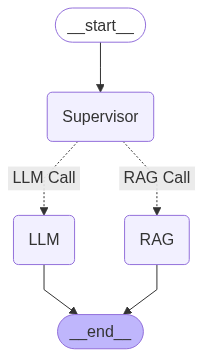

In [76]:
app = workflow.compile()

In [ ]:
workflow.compile()


In [77]:
from langchain_core.messages import HumanMessage

state = {"messages": [HumanMessage(content="what is the weather today")]}
# state = AgentState(messages=["hi"]) # this is wrong!!! It won't work. AgentState is a TypedDict, not a regular class. TypedDict is just a type hint - it doesn't create a constructor.

In [78]:
app.invoke(state)

Question what is the weather today
Parsed response: Topic='Not Related' Reasoning="The user query 'what is the weather today' is a general question about weather and does not contain any specific reference or keyword related to the USA. Therefore, it does not fit the 'USA' category."
-> ROUTER ->
last_message: Not Related
-> LLM Call ->


{'messages': [HumanMessage(content='what is the weather today', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Not Related', additional_kwargs={}, response_metadata={}),
  AIMessage(content='I cannot tell you the weather directly because I don\'t know your current location! Weather is very localized.\n\nTo get accurate information, please tell me:\n\n*   **Your city and state/country** (e.g., "weather in London, UK" or "weather in New York City, NY").\n\nAlternatively, you can easily check the weather yourself using:\n\n*   **A weather app on your phone** (like AccuWeather, The Weather Channel, Google Weather).\n*   **A quick search on Google or another search engine** (e.g., "weather near me" or "weather in [your city]").\n*   **A smart assistant** (like Siri, Alexa, or Google Assistant) by asking "What\'s the weather like today?"', additional_kwargs={}, response_metadata={})]}

In [83]:
state = {"messages": [HumanMessage(content="what is a gdp of usa?")]}

In [82]:
app.invoke(state)

Question what is a gdp of usa?
Parsed response: Topic='USA' Reasoning="The user query directly asks for information about the 'USA' (GDP of USA)."
-> ROUTER ->
last_message: USA
-> RAG Call ->


{'messages': [HumanMessage(content='what is a gdp of usa?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='USA', additional_kwargs={}, response_metadata={}),
  AIMessage(content="As of 2024, the United States' nominal GDP is estimated to be around $28 trillion USD. This accounts for approximately 25% of the global economy. The U.S. ranks #1 in the world by nominal GDP.", additional_kwargs={}, response_metadata={})]}

In [ ]:
function_1(state)

Question what is a today weather?
Parsed response: Topic='Not Related' Reasoning="The user query asks about 'today weather' which is a general topic and does not specify or imply any relation to the USA."


{'messages': [AIMessage(content='Not Related', additional_kwargs={}, response_metadata={})]}

In [86]:
state = {"messages": [HumanMessage(content="can you tell me the industrial growth of world's most powerful economy?")]}

In [88]:
state = {"messages": [HumanMessage(content="can you tell me the industrial growth of world's poor economy?")]}

In [87]:
result=app.invoke(state)

Question can you tell me the industrial growth of world's most powerful economy?
Parsed response: Topic='USA' Reasoning="The user query asks about the 'world's most powerful economy', which is widely recognized as referring to the United States of America."
-> ROUTER ->
last_message: USA
-> RAG Call ->


In [89]:
result["messages"][-1]

AIMessage(content="Based on the provided context, the United States of America possesses the largest and most powerful economy in the world. However, the context does not provide information regarding its industrial growth. Therefore, I cannot tell you the industrial growth of the world's most powerful economy.", additional_kwargs={}, response_metadata={})